**Advanced Feature Engineering with Temporal and Rolling Statistics for Time Series Data**

This function transforms raw data by extracting detailed time-based features such as hour, day of the week, quarter, and weekend indicators. It also computes rolling statistics including mean, standard deviation, median, and skewness—over a 7-day window to capture trends and variability in emissions and production volumes. Additionally, it creates lagged features and their corresponding changes for multiple time steps (1, 3, and 7 days) to model delayed effects in the data.

In [ ]:
def engineer_features(df):
    # Convert timestamp to datetime and sort
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Extract time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_of_month'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['quarter'] = df['timestamp'].dt.quarter
    
    # Calculate emission intensity
    df['emission_intensity'] = df['emissions'] / (df['production_volume'] + 1e-6)
    
    rolling_window = 7  
    
    # Rolling stats on emissions
    df['rolling_mean_emissions'] = df['emissions'].rolling(window=rolling_window, min_periods=1).mean()
    df['rolling_std_emissions'] = df['emissions'].rolling(window=rolling_window, min_periods=1).std()
    df['rolling_max_emissions'] = df['emissions'].rolling(window=rolling_window, min_periods=1).max()
    df['rolling_median_emissions'] = df['emissions'].rolling(window=rolling_window, min_periods=1).median()
    df['rolling_skew_emissions'] = df['emissions'].rolling(window=rolling_window, min_periods=1).apply(lambda x: x.skew() if len(x) > 2 else 0)
    
    # Rolling mean and intensity for production
    df['rolling_mean_production'] = df['production_volume'].rolling(window=rolling_window, min_periods=1).mean()
    df['rolling_emission_intensity'] = df['rolling_mean_emissions'] / (df['rolling_mean_production'] + 1e-6)
    
    # Lag features
    for lag in [1, 3, 7]:
        df[f'lag{lag}_emissions'] = df['emissions'].shift(lag)
        df[f'lag{lag}_production'] = df['production_volume'].shift(lag)
    
    # Change from previous lags
    for lag in [1, 3, 7]:
        df[f'emission_change_lag{lag}'] = df['emissions'] - df[f'lag{lag}_emissions']
        df[f'production_change_lag{lag}'] = df['production_volume'] - df[f'lag{lag}_production']
    
    # Fill missing values
    df = df.fillna(method='bfill').fillna(method='ffill')
    
    return df


**Feature Selection Using Statistical and Recursive Methods for Model Optimization**

This function provides two methods for selecting the most relevant features from a dataset: the statistical SelectKBest method, which uses regression scores to pick the top features, and Recursive Feature Elimination (RFE) with a Random Forest estimator, which iteratively removes less important features to find the best subset. By adjusting the number of selected features and the elimination step size, the method balances precision and computation time. It returns both the chosen features and a sorted importance score, helping to improve model accuracy and interpretability by focusing on the most informative variables.

In [ ]:
def select_features(X, y, method='kbest', k=10):
    if method == 'kbest':
        # Select top k features using univariate regression test
        selector = SelectKBest(score_func=f_regression, k=k)
        selector.fit(X, y)
        selected_features = X.columns[selector.get_support()]
        scores = selector.scores_
    
    elif method == 'rfe':
        # Use Recursive Feature Elimination with Random Forest
        estimator = RandomForestRegressor(n_estimators=100, random_state=42)
        selector = RFE(estimator, n_features_to_select=k, step=0.1)
        selector.fit(X, y)
        selected_features = X.columns[selector.support_]
        # Higher score = more important
        scores = (len(selector.ranking_) + 1) - selector.ranking_
    
    else:
        # Raise error if method is invalid
        raise ValueError("Method must be 'kbest' or 'rfe'")
    
    # Create DataFrame of features and their scores
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Score': scores
    }).sort_values('Score', ascending=False)
    
    return selected_features, feature_importance


**Model Interpretation and Validation Using SHAP Values**

This function trains a Random Forest regressor on the selected features and uses SHAP (SHapley Additive exPlanations) to interpret the model's predictions. By computing SHAP values, it quantifies the contribution of each feature to the output, providing transparent insight into feature importance. 

In [22]:
def validate_with_shap(X, y, selected_features):
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X[selected_features], y)
    
    explainer = shap.Explainer(model, X[selected_features])
    shap_values = explainer(X[selected_features])
    
    shap.summary_plot(shap_values, X[selected_features], plot_type="bar", max_display=15)
    shap.summary_plot(shap_values, X[selected_features], max_display=15)
    
    return shap_values


**Pipeline Execution and Feature Analysis**

This script demonstrates a complete workflow starting from synthetic data generation to feature engineering, selection, and validation. It creates a time series dataset simulating emissions and production volumes, then applies feature engineering to extract temporal and statistical attributes. A target variable is generated based on a combination of engineered features plus noise to simulate a realistic prediction task. Feature selection is performed using recursive feature elimination (RFE) to identify the most relevant predictors. Finally, the model’s interpretability is assessed using SHAP values, providing visual insights into feature contribution.

C:\Users\rouat\AppData\Local\Temp\ipykernel_13276\20824734.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


Selected Features: ['rolling_std_emissions', 'rolling_skew_emissions', 'rolling_emission_intensity', 'emission_change_lag1', 'production_change_lag1', 'production_change_lag3', 'emission_change_lag7', 'production_change_lag7']

Feature Importance:
                       Feature  Score
27      production_change_lag7     28
26        emission_change_lag7     28
25      production_change_lag3     28
23      production_change_lag1     28
10       rolling_std_emissions     28
22        emission_change_lag1     28
15  rolling_emission_intensity     28
13      rolling_skew_emissions     28
1            production_volume     27
9       rolling_mean_emissions     27
3                  day_of_week     26
8           emission_intensity     26
4                 day_of_month     25
24        emission_change_lag3     25
14     rolling_mean_production     24
11       rolling_max_emissions     24
16              lag1_emissions     23
0                    emissions     23
12    rolling_median_emissions

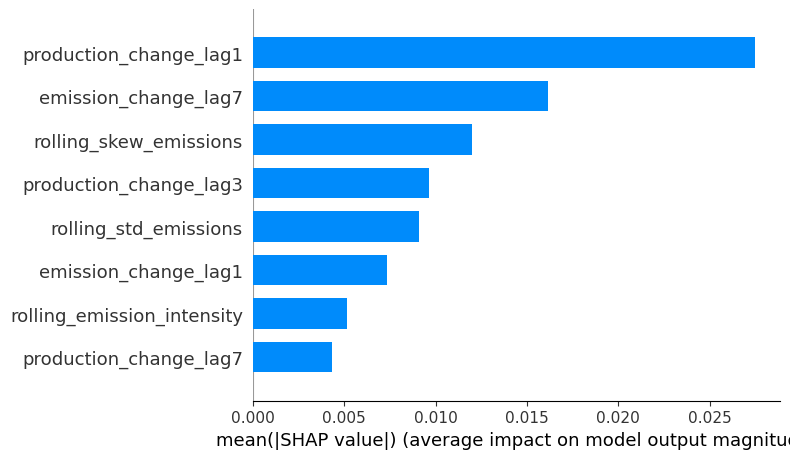

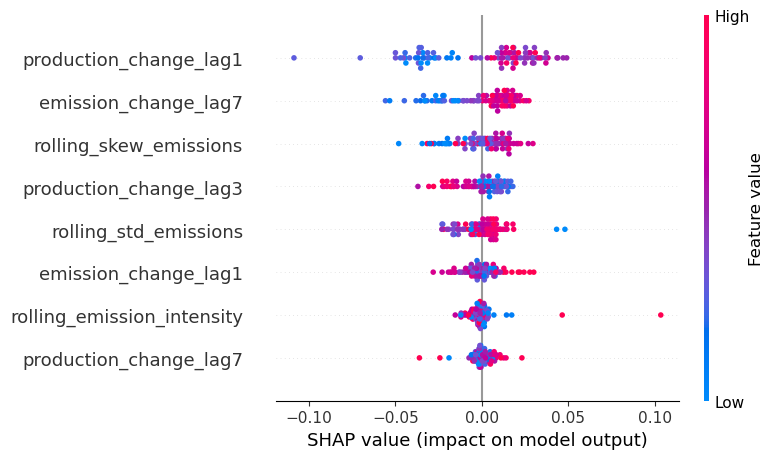

In [24]:
if __name__ == "__main__":
    dates = pd.date_range('2024-01-01', '2024-03-31')
    emissions = np.random.normal(100, 20, len(dates)).cumsum()
    production = np.random.normal(50, 10, len(dates)).cumsum()
    
    df = pd.DataFrame({
        'timestamp': dates,
        'emissions': emissions,
        'production_volume': production
    })
    
    df = engineer_features(df)
    
    y = 0.5 * df['emission_intensity'] + 0.3 * df['hour'] + np.random.normal(0, 0.1, len(df))
    
    X = df.drop(columns=['timestamp'])
    selected_features, feature_importance = select_features(X, y, method='rfe', k=8)
    
    print("Selected Features:", list(selected_features))
    print("\nFeature Importance:")
    print(feature_importance)
    
    shap_values = validate_with_shap(X, y, selected_features)
